## Introduction
With this notebook I want to explore the non-professional developer population at the Stack Overflow Annual Survey to have some idea of who is this population.

From the most recent survey results (2019) we will look at this non-professional developer population profile.
We will take a look at career and job satisfaction comparing the professional and non-professional developers.

In [2]:
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3, venn3_circles
import plotly.express as px
import seaborn as sns

%matplotlib inline

df = pd.read_csv('./stackoverflow/2019.csv')
df.describe()

,Respondent,CompTotal,ConvertedComp,WorkWeekHrs,CodeRevHrs,Age
count,88883.000000,5.594500e+04,5.582300e+04,64503.000000,49790.000000,79210.000000
mean,44442.000000,5.519014e+11,1.271107e+05,42.127197,5.084308,30.336699
std,25658.456325,7.331926e+13,2.841523e+05,37.287610,5.513931,9.178390
min,1.000000,0.000000e+00,0.000000e+00,1.000000,0.000000,1.000000
25%,22221.500000,2.000000e+04,2.577750e+04,40.000000,2.000000,24.000000
50%,44442.000000,6.200000e+04,5.728700e+04,40.000000,4.000000,29.000000
75%,66662.500000,1.200000e+05,1.000000e+05,44.750000,6.000000,35.000000
max,88883.000000,1.000000e+16,2.000000e+06,4850.000000,99.000000,99.000000


As the population we want to focus at this data exploration are the non-professional developers, let's take a look at the information that can potentially help us with this filter:
* **MainBranch:** Which of the following options best describes you today? Here, by "developer" we mean "someone who writes code."
* **Hobbyist:** Do you code as a hobby?

In [103]:
## uncomment to see all the questions
#df2 = pd.read_csv('./stackoverflow/2019_schema.csv')
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     print(df2)
mainbranch = df['MainBranch'].value_counts().reset_index()
#mainbranch.head()
mainbranch.rename(columns={'index': 'What option best describes you today?', 'MainBranch': 'Count'}, inplace=True)
mainbranch['Percent'] = mainbranch.Count / (len(df['MainBranch'])-df['MainBranch'].isnull().sum())
mainbranch.style.format({'Count': "{:,}", 'Percent': '{:.2%}'})

,What option best describes you today?,Count,Percent
0,I am a developer by profession,"65,679",74.36%
1,I am a student who is learning to code,"10,189",11.54%
2,"I am not primarily a developer, but I write code sometimes as part of my work","7,539",8.53%
3,I code primarily as a hobby,"3,340",3.78%
4,"I used to be a developer by profession, but no longer am","1,584",1.79%


In [104]:
df['MainBranch']

0                   I am a student who is learning to code
1                   I am a student who is learning to code
2        I am not primarily a developer, but I write co...
3                           I am a developer by profession
4                           I am a developer by profession
                               ...                        
88878                                                  NaN
88879                                                  NaN
88880                                                  NaN
88881                                                  NaN
88882                                                  NaN
Name: MainBranch, Length: 88883, dtype: object

In [105]:
n_answers = len(df['MainBranch'])-df['MainBranch'].isnull().sum()
study_pop = mainbranch.iloc[2, 1]+ mainbranch.iloc[3, 1]
perc_pop = study_pop/n_answers

print("The population we will be looking into will be a total of {a:,} survey answers.\n\
This represents {b:.2f}% of the total population".format(a=study_pop, b=perc_pop*100))

The population we will be looking into will be a total of 10,879 survey answers.
This represents 12.32% of the total population


I would like to focus on professionals who are developing their programming skills, but who are not professional developers nor were professional developers in the past.
I would also like to exclude the "student" population from the dataset.
Before deciding simplifying our data set only with the population of our interest and only with the relevant columns, let's take a look at the "hobbyist" column.

In [106]:
df_study = df.copy()
df_study = df[['Respondent','MainBranch','Hobbyist','Employment','Country','Student','EdLevel','UndergradMajor',\
                 'EduOther','OrgSize','YearsCode','Age1stCode','YearsCodePro','CareerSat','JobSat',\
                 'MgrIdiot','MgrMoney','MgrWant','JobSeek','LastHireDate','JobFactors','CurrencySymbol',\
                 'CurrencyDesc','CompTotal','CompFreq','ConvertedComp','WorkWeekHrs','WorkPlan','ImpSyn',\
                 'Age','Gender','Trans','Sexuality','Ethnicity','Dependents']]
ans1 = 'I am not primarily a developer, but I write code sometimes as part of my work'
ans2 = 'I code primarily as a hobby'

df_study = df_study[(df.MainBranch == ans1)| (df.MainBranch == ans2)]
df_study.describe()
#df_study.to_csv(r'study.csv')

,Respondent,CompTotal,ConvertedComp,WorkWeekHrs,Age
count,10879.00000,5.335000e+03,5.321000e+03,6338.000000,9363.000000
mean,44259.66826,1.712797e+07,1.280838e+05,42.308780,31.500726
std,25576.14766,1.118772e+09,2.802068e+05,21.548771,11.709361
min,3.00000,0.000000e+00,0.000000e+00,1.000000,1.000000
25%,22005.00000,1.500000e+04,2.700000e+04,40.000000,24.000000
50%,44056.00000,5.672400e+04,5.572800e+04,40.000000,30.000000
75%,66323.00000,1.100000e+05,1.000000e+05,45.000000,38.000000
max,88880.00000,8.152866e+10,2.000000e+06,425.000000,99.000000


## Population profile

In [107]:
hob = df_study['Hobbyist'].value_counts().reset_index()
hob.rename(columns={'index': 'Hobbyist', 'Hobbyist': 'Count'}, inplace=True)
hob['Percent'] = hob.Count / study_pop
hob.style.format({'Count': "{:,}", 'Percent': '{:.2%}'})

,Hobbyist,Count,Percent
0,Yes,"9,187",84.45%
1,No,"1,692",15.55%


The majority of this population, 84.45%, code as a hobby.

I will isolate the population of interest and also disregard all the columns that are not important for our study:
* Population chacteristc features;
* Educational level;
* Coding experience;
* Job satisfaction related questions.

We have some numerical answers within these features of interest, so we will probably have to treat NA answers.
Before taking a look at the numerical features, let's get some sense of the categorical features.

In [108]:
# Which of the following do you currently identify as? Please select all that apply. If you prefer not to answer, you may leave this question blank.
male = len(df_study[(df_study.Gender == 'Man')])
female = len(df_study[(df_study.Gender == 'Woman')])
others = study_pop - female - male
print("Percentage of man in our population study is {:.0f}% and woman, {:.0f}%. Other classifications represents {:.0f}%."\
     .format(male/study_pop*100, female/study_pop*100, others/study_pop*100))


gender = df_study['Gender'].value_counts().reset_index()
gender

Percentage of man in our population study is 86% and woman, 8%. Other classifications represents 6%.


,index,Gender
0,Man,9354
1,Woman,844
2,"Non-binary, genderqueer, or gender non-conforming",86
3,"Man;Non-binary, genderqueer, or gender non-con...",31
4,"Woman;Non-binary, genderqueer, or gender non-c...",30
5,Woman;Man,20
6,"Woman;Man;Non-binary, genderqueer, or gender n...",17


In [109]:
# In which country do you currently reside?
country = df_study['Country'].value_counts().reset_index()
country.rename(columns={'index': 'Country', 'Country': 'Count'}, inplace=True)
country['Percent'] = country.Count / (study_pop-df_study['Country'].isnull().sum())
country.style.format({'Count': "{:,}", 'Percent': '{:.2%}'})

,Country,Count,Percent
0,United States,"2,768",25.44%
1,Germany,832,7.65%
2,United Kingdom,701,6.44%
3,India,643,5.91%
4,Canada,429,3.94%
5,France,306,2.81%
6,Australia,289,2.66%
7,Netherlands,246,2.26%
8,Brazil,235,2.16%
9,Italy,235,2.16%


In [110]:
# Which of the following best describes the highest level of formal education that you've completed?
edu = df_study['EdLevel'].value_counts().reset_index()
edu.rename(columns={'index': 'Educational Level', 'EdLevel': 'Count'}, inplace=True)
edu['Percent'] = edu.Count / (study_pop-df_study['EdLevel'].isnull().sum())
edu.style.format({'Count': "{:,}", 'Percent': '{:.2%}'})

,Educational Level,Count,Percent
0,"Bachelor’s degree (BA, BS, B.Eng., etc.)","3,258",31.32%
1,"Master’s degree (MA, MS, M.Eng., MBA, etc.)","2,595",24.94%
2,"Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)","1,398",13.44%
3,Some college/university study without earning a degree,"1,242",11.94%
4,"Other doctoral degree (Ph.D, Ed.D., etc.)",824,7.92%
5,Primary/elementary school,470,4.52%
6,Associate degree,318,3.06%
7,"Professional degree (JD, MD, etc.)",179,1.72%
8,I never completed any formal education,119,1.14%


In [111]:
# What was your main or most important field of study?
major = df_study['UndergradMajor'].value_counts().reset_index()
major.rename(columns={'index': 'Undergrad Major', 'UndergradMajor': 'Count'}, inplace=True)
major['Percent'] = major.Count / (study_pop-df_study['UndergradMajor'].isnull().sum()-180)
major.style.format({'Count': "{:,}", 'Percent': '{:.2%}'})

,Undergrad Major,Count,Percent
0,"Computer science, computer engineering, or software engineering","2,878",35.40%
1,"Another engineering discipline (ex. civil, electrical, mechanical)","1,300",15.99%
2,"A natural science (ex. biology, chemistry, physics)",861,10.59%
3,"Information systems, information technology, or system administration",797,9.80%
4,Mathematics or statistics,608,7.48%
5,"A business discipline (ex. accounting, finance, marketing)",483,5.94%
6,"A social science (ex. anthropology, psychology, political science)",334,4.11%
7,"A humanities discipline (ex. literature, history, philosophy)",306,3.76%
8,Web development or web design,220,2.71%
9,"Fine arts or performing arts (ex. graphic design, music, studio art)",218,2.68%


In [112]:
# "Which of the following best describes your current employment status?"
emp = df_study['Employment'].value_counts().reset_index()
emp.rename(columns={'index': 'Employment status', 'Employment': 'Count'}, inplace=True)
emp['Percent'] = emp.Count / (study_pop-df_study['Employment'].isnull().sum())
emp.style.format({'Count': "{:,}", 'Percent': '{:.2%}'})


,Employment status,Count,Percent
0,Employed full-time,"6,680",64.22%
1,"Independent contractor, freelancer, or self-employed","1,191",11.45%
2,"Not employed, and not looking for work","1,022",9.83%
3,"Not employed, but looking for work",783,7.53%
4,Employed part-time,600,5.77%
5,Retired,126,1.21%


In [113]:
# dataset = emp
# #layout = go.Layout(yaxis=dict(tickformat=".2%"))
# fig = px.bar(dataset, x='Employment status', y='Percentage')
# fig.show()

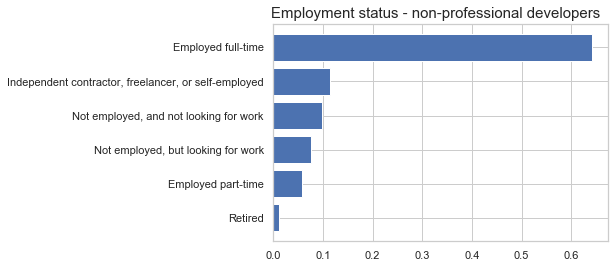

In [116]:
# data to plot
height = emp['Percent']
bars = emp['Employment status']
y_pos = np.arange(len(bars))
 
# Create horizontal bars
ax = plt.barh(y_pos, height)
 
# Create names on the y-axis
plt.yticks(y_pos, bars)
plt.gca().invert_yaxis() 
plt.figtext(.5,.9,'Employment status - non-professional developers', fontsize=15, ha='center')
# Show graphic
plt.show()

In [117]:
# "Approximately how many people are employed by the company or organization you work for?"
size = df_study['OrgSize'].value_counts().reset_index()
size.rename(columns={'index': 'Organization size', 'OrgSize': 'Count'}, inplace=True)
size['Percent'] = size.Count / (study_pop-df_study['OrgSize'].isnull().sum())
size.style.format({'Count': "{:,}", 'Percent': '{:.2%}'})

,Organization size,Count,Percent
0,"10,000 or more employees","1,587",19.57%
1,100 to 499 employees,"1,257",15.50%
2,20 to 99 employees,"1,190",14.67%
3,"1,000 to 4,999 employees","1,005",12.39%
4,"Just me - I am a freelancer, sole proprietor, etc.",813,10.02%
5,2-9 employees,714,8.80%
6,500 to 999 employees,566,6.98%
7,10 to 19 employees,506,6.24%
8,"5,000 to 9,999 employees",473,5.83%


## Coding experience

We know that this population only have the individuals who responded that they do not work as a developer, has not worked in the past and are not students. But how much experience do they have? We will look now at the following questions:
* Including any education, how many years have you been coding?
* At what age did you write your first line of code or program?

Probably some people did not reply this questions. Let's check how signifficant this percentage of empty values is.

In [118]:
nulls = df_study.isnull().sum()/study_pop
print("The percentage of nulls is: {:.2%} for YearsCode, {:.2%} for Age1stCode, and {:.2%} for Age."\
      .format(nulls['YearsCode'], nulls['Age1stCode'], nulls['Age']))

The percentage of nulls is: 1.54% for YearsCode, 1.81% for Age1stCode, and 13.94% for Age.


In [119]:
# copy df as we are going to replace some values
df_age = df_study.copy()
df_age = df_age.dropna(subset=['YearsCode', 'Age1stCode', 'Age'])
study_age = len(df_age['Age'])
print("By dropping the rows with null value in any of the columns, our new population is {:,},\
 which is {:.2%} the of population snippet we started with.".format(study_age,study_age/study_pop))

By dropping the rows with null value in any of the columns, our new population is 9,284, which is 85.34% the of population snippet we started with.


We still got a signifficant amount of responses (>85%) if we remove the null cases.

These columns are string type in the survey file because they have non-numerical option answers. To plot the distributions we need all values as numerical. Let's assume "Less than..." and "Younger than..." as the integer immediately below and "More than..." and "Older than..." as the integer immediately above. Then let's convert the whole column to integer type.

In [120]:
df_age['YearsCode'].replace(["Less than 1 year","More than 50 years"],[0,50],inplace=True)
df_age['Age1stCode'].replace(['Younger than 5 years','Older than 85'],[4,86],inplace=True)

df_age['YearsCode'] = df_age['YearsCode'].astype(int)
df_age['Ages1stCode'] = df_age['Age1stCode'].astype(int)

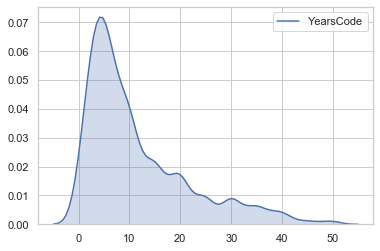

In [121]:
# density plot with shade
sns.kdeplot(df_age['YearsCode'], shade=True);

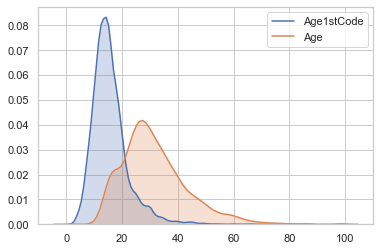

In [122]:
p1=sns.kdeplot(df_age['Age1stCode'], shade=True)
p1=sns.kdeplot(df_age['Age'], shade=True)

In [123]:
df_age.describe()

,Respondent,YearsCode,CompTotal,ConvertedComp,WorkWeekHrs,Age,Ages1stCode
count,9284.000000,9284.000000,5.047000e+03,5.035000e+03,5817.000000,9284.000000,9284.000000
mean,44250.278759,11.528113,6.689839e+05,1.275461e+05,42.260538,31.485276,15.677833
std,25559.776746,10.188283,8.851914e+06,2.786761e+05,21.445076,11.680373,6.505257
min,3.000000,0.000000,0.000000e+00,0.000000e+00,1.000000,1.000000,4.000000
25%,21979.500000,4.000000,1.500000e+04,2.711400e+04,40.000000,24.000000,12.000000
50%,44374.500000,8.000000,5.558300e+04,5.556900e+04,40.000000,30.000000,15.000000
75%,66262.750000,16.000000,1.100000e+05,1.000000e+05,45.000000,38.000000,18.000000
max,88849.000000,50.000000,3.900000e+08,2.000000e+06,425.000000,99.000000,86.000000


More than 75% of the respondents started coding when they were 18 years old or younger. The median age is 15 years old.
Comparing the median age (30) with the median age of first coding experience (15) there is a period of 15 years. The respondents, at median, have been coding for 8 years, so there is a gap.

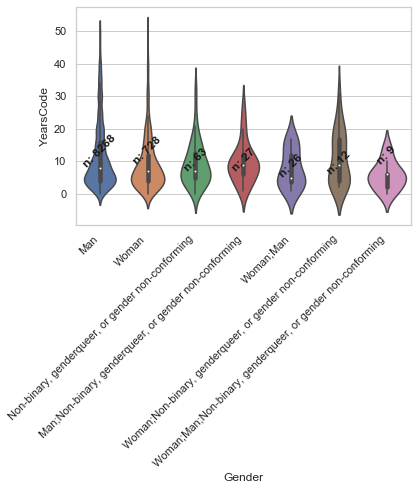

In [124]:
# sns.boxplot(x="Gender", y="YearsCode", data=df_study, palette="Set1");
# Basic violinplot
ax = sns.violinplot(x="Gender", y="YearsCode", data=df_age)
 
# Calculate number of obs per group & median to position labels
medians = df_age.groupby(['Gender'])['YearsCode'].median().values
nobs = df_age['Gender'].value_counts().values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n: " + i for i in nobs]
 
# Add it to the plot
pos = range(len(nobs))
for tick,label in zip(pos,ax.get_xticklabels()):\
   ax.text(pos[tick], medians[tick] + 0.03, nobs[tick], horizontalalignment='center', size='large', color='k', weight='semibold', rotation=45)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right');

## Career / Job satisfaction

We would also like to know about the respondents' job satisfaction. Are they dissatisfied with their current careers / jobs? Here are the questions we will be looking into:
* Overall, how satisfied are you with your career thus far?
* How satisfied are you with your current job? 
* How confident are you that your manager knows what they're doing?
* Which of the following best describes your current job-seeking status?

All features in this part are categorical and they all relate to job / career satisfaction. Let's give a score for the answers try to understand a little bit better beyond looking at each answer individually.

Let's give the following scores to the range of responses:

| Career and job satisfaction         | Score   |
| --- | --- |
|   Very satisfied  | +2      |
|   Slightly satisfied  | +1|
|   Neither satisfied nor dissatisfied  | 0|
|   Slightly dissatisfied  | -1|
|   Very dissatisfied  | -2|

| Conf. Manager         | Score   |
| --- | --- |
|   Very confident  | +2      |
|  Somewhat confident  | +1|
|   I don't have a manager  | 0|
|  Not at all confident  | -1|

| Job-seeking        | Score   |
| --- | --- |
|   I am not interested in new job opportunities  | +1      |
| I'm not actively looking, but I am open to new opportunities  | 0|
|  I am actively looking for a job  | -1|

For null responses, we will assume value zero.

In [224]:
# copy df as we are going to replace some values
df_job = df_study.copy()
df_job['CareerSat'].replace(['Very satisfied','Slightly satisfied', 'Neither satisfied nor dissatisfied',\
                            'Slightly dissatisfied','Very dissatisfied'],[2, 1, 0, -1, -2],inplace=True)
df_job['JobSat'].replace(['Very satisfied','Slightly satisfied', 'Neither satisfied nor dissatisfied',\
                            'Slightly dissatisfied','Very dissatisfied'],[2, 1, 0, -1, -2],inplace=True)
df_job['MgrIdiot'].replace(['Very confident','Somewhat confident', "I don't have a manager",\
                            'Not at all confident'],[2, 1, 0, -1],inplace=True)
df_job['JobSeek'].replace(['I am not interested in new job opportunities',"I’m not actively looking, but I am open to new opportunities",\
                            'I am actively looking for a job'],[1, 0, -1],inplace=True)
# exclude na
df_job = df_job.dropna(subset=['CareerSat', 'JobSat', 'MgrIdiot', 'JobSeek'])

# create new column with the score
df_job['SatScore'] = df_job['CareerSat']+df_job['JobSat']+df_job['MgrIdiot']+df_job['JobSeek']


In [226]:
df_job['SatScore'].describe()

count    5607.000000
mean        2.501338
std         3.069354
min        -6.000000
25%         0.000000
50%         3.000000
75%         5.000000
max         7.000000
Name: SatScore, dtype: float64

How does our study population compare to the whole survey population?

In [272]:
df_job_all = df.copy()
df_job_all['CareerSat'].replace(['Very satisfied','Slightly satisfied', 'Neither satisfied nor dissatisfied',\
                            'Slightly dissatisfied','Very dissatisfied'],[2, 1, 0, -1, -2],inplace=True)
df_job_all['JobSat'].replace(['Very satisfied','Slightly satisfied', 'Neither satisfied nor dissatisfied',\
                            'Slightly dissatisfied','Very dissatisfied'],[2, 1, 0, -1, -2],inplace=True)
df_job_all['MgrIdiot'].replace(['Very confident','Somewhat confident', "I don't have a manager",\
                            'Not at all confident'],[2, 1, 0, -1],inplace=True)
df_job_all['JobSeek'].replace(['I am not interested in new job opportunities',"I’m not actively looking, but I am open to new opportunities",\
                            'I am actively looking for a job'],[1, 0, -1],inplace=True)
# drop na
df_job_all = df_job_all.dropna(subset=['CareerSat', 'JobSat', 'MgrIdiot', 'JobSeek'])

# create new column with the score
df_job_all['JobSeek'] = df_job_all['JobSeek'].fillna(0)
df_job_all['SatScore'] = df_job_all['CareerSat']+df_job_all['JobSat']+df_job_all['MgrIdiot']+df_job_all['JobSeek']

df_job_all['SatScore'].describe()

count    59399.000000
mean         2.852506
std          2.964880
min         -6.000000
25%          1.000000
50%          3.000000
75%          5.000000
max          7.000000
Name: SatScore, dtype: float64

Text(3.137756527887675, 7337.242499999999, 'Mean: 2.85')

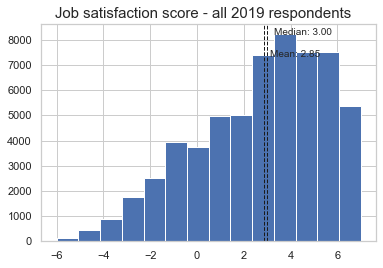

In [267]:
plt.hist(df_job_all['SatScore'], bins=14);
plt.figtext(.5,.9,'Job satisfaction score - all 2019 respondents', fontsize=15, ha='center');
plt.axvline(x.median(), color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(x.median()*1.1, max_ylim*0.95, 'Median: {:.2f}'.format(x.median()))
plt.axvline(x.mean(), color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(x.mean()*1.1, max_ylim*0.85, 'Mean: {:.2f}'.format(x.mean()))

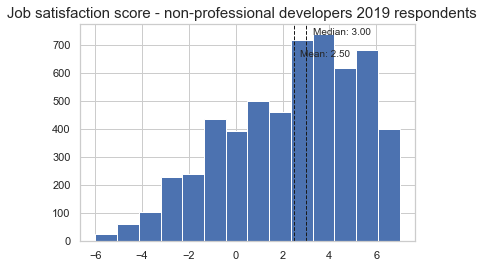

In [271]:
x1 = df_job['SatScore']
plt.hist(x1, bins=14);
plt.figtext(.5,.9,'Job satisfaction score - non-professional developers 2019 respondents', fontsize=15, ha='center');
plt.axvline(x1.median(), color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
l11 = plt.text(x1.median()*1.1, max_ylim*0.95, 'Median: {:.2f}'.format(x1.median()))
l11 = plt.axvline(x1.mean(), color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
l12 = plt.text(x1.mean()*1.1, max_ylim*0.85, 'Mean: {:.2f}'.format(x1.mean()))

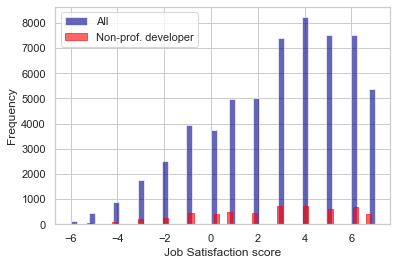

In [219]:
hist = sns.distplot( a=df_job_all["SatScore"], color='darkblue',hist=True, kde=False,hist_kws={"rwidth":1, 'alpha':0.6});
hist = sns.distplot( a=df_job["SatScore"],color='red', hist=True, kde=False, hist_kws={"edgecolor":'red',"rwidth":0.4, 'alpha':0.6});
hist.set(xlabel='Job Satisfaction score', ylabel='Frequency');
plt.legend(['All','Non-prof. developer'], ncol=1, loc=0);

In [223]:
df_job['SatScore']
df_job.to_csv('satscore.csv')

It seems that the whole population is more satisfied with their jobs and careers compared to our snippet of non-professional developers. What is the percentage of the respodents who are actively looking for a job or willing to consider new opportunities?

In [211]:
jobseek = df_study['JobSeek'].value_counts().reset_index()
jobseek.rename(columns={'index': 'Job Seek - non-professional developers', 'JobSeek': 'Count'}, inplace=True)
jobseek['Percent'] = jobseek.Count / (study_pop-df_study['JobSeek'].isnull().sum())
jobseek.style.format({'Count': "{:,}", 'Percent': '{:.2%}'})

,Job Seek - non-professional developers,Count,Percent
0,"I’m not actively looking, but I am open to new opportunities","4,471",60.11%
1,I am not interested in new job opportunities,"1,818",24.44%
2,I am actively looking for a job,"1,149",15.45%


In [25]:
jobseek_all = df['JobSeek'].value_counts().reset_index()
jobseek_all.rename(columns={'index': 'Job Seek - All respondents', 'JobSeek': 'Count'}, inplace=True)
jobseek_all['Percent'] = jobseek_all.Count / (n_answers-df['JobSeek'].isnull().sum())
jobseek_all.style.format({'Count': "{:,}", 'Percent': '{:.2%}'})

,Job Seek - All respondents,Count,Percent
0,"I’m not actively looking, but I am open to new opportunities","47,260",58.67%
1,I am not interested in new job opportunities,"21,080",26.17%
2,I am actively looking for a job,"12,215",15.16%


Compared to the overall population, the job-seeking status for our study population has similar distribution.

## How this population evolved over the years?

We have the data from 2011 to 2019, however we can only indentify non-professional developers starting from 2017 survey.

Then, let's use the data for the years 2017 to 2019.

In [5]:
df_2018 = pd.read_csv('./stackoverflow/2018.csv')
df_2017 = pd.read_csv('./stackoverflow/2017.csv')

For 2019 survey we have to look at MainBranch question.
Let's take a look at the questions for 2018 and 2017.

In [27]:
df2_2018 = pd.read_csv('./stackoverflow/2018_schema.csv')
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df2_2018)

                          Column  \
0                     Respondent   
1                          Hobby   
2                     OpenSource   
3                        Country   
4                        Student   
5                     Employment   
6                FormalEducation   
7                 UndergradMajor   
8                    CompanySize   
9                        DevType   
10                   YearsCoding   
11               YearsCodingProf   
12               JobSatisfaction   
13            CareerSatisfaction   
14                 HopeFiveYears   
15               JobSearchStatus   
16                    LastNewJob   
17                    AssessJob1   
18                    AssessJob2   
19                    AssessJob3   
20                    AssessJob4   
21                    AssessJob5   
22                    AssessJob6   
23                    AssessJob7   
24                    AssessJob8   
25                    AssessJob9   
26                   AssessJ

For 2018 we will the following question:
* **DevType**: Which of the following describe you? Please select all that apply.


In [28]:
df2_2017 = pd.read_csv('./stackoverflow/2017_schema.csv')
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df2_2017)

                               Column  \
0                          Respondent   
1                        Professional   
2                        ProgramHobby   
3                             Country   
4                          University   
5                    EmploymentStatus   
6                     FormalEducation   
7                      MajorUndergrad   
8                          HomeRemote   
9                         CompanySize   
10                        CompanyType   
11                       YearsProgram   
12                      YearsCodedJob   
13                  YearsCodedJobPast   
14                      DeveloperType   
15                   WebDeveloperType   
16                MobileDeveloperType   
17                   NonDeveloperType   
18                 CareerSatisfaction   
19                    JobSatisfaction   
20                      ExCoderReturn   
21                    ExCoderNotForMe   
22                     ExCoderBalance   
23              

For 2017 data we can use:
* **Professional**: Which of the following best describes you?

It will be more difficult to identify our group of interest from 2018 data because the respondents selected all options that applied. What we will try to do is count only the rows that does not contain professional developer terms in the answer.

From the database we can create a list of the possible values and the list of the values I identify as something like a professional developer:

In [75]:
possible_vals = ['Full-stack developer','Database administrator','DevOps specialist','System administrator',
                 'Engineering manager','Data or business analyst','Desktop or enterprise applications developer',
                 'Game or graphics developer','QA or test developer','Student','Back-end developer',
                 'Front-end developer','Designer','C-suite executive (CEO, CTO, etc.)','Mobile developer',
                 'Data scientist or machine learning specialist','Marketing or sales professional',
                 'Product manager','Embedded applications or devices developer','Educator or academic researcher']
values_prof_dev = ['Full-stack developer','Database administrator','DevOps specialist','System administrator',
                   'Engineering manager','Data or business analyst','Desktop or enterprise applications developer',
                   'Game or graphics developer','QA or test developer','Student','Back-end developer',
                   'Front-end developer','Designer','Mobile developer','Data scientist or machine learning specialist',
                   'Product manager','Embedded applications or devices developer']
# I want to exclude from the population students and null answers. I will work only with the remaining population
df_2018 =  df_2018.dropna(subset=['DevType'])
df_2018 = df_2018[df_2018.columns.drop(list(df_2018.filter(regex='Student')))]
total2018=len(df_2018['Respondent'])
# Now we will create a column to indicate if the respondent is a professional developer or not

prof2018 = 0

for idx in range(len(df_2018['DevType'].values)):
    if ';' in df_2018['DevType'].values[idx]:
        profs = df_2018['DevType'].values[idx].split(';')
    else:
        profs = [df_2018['DevType'].values[idx]]
    
    for val in profs:
        if val in values_prof_dev:
            prof2018+=1
            break

1 - prof2018/total2018
            

0.019718126343677422

Less than 1% selected an option that is clearly not related to a programming activity (like C-suite, Marketing/Sales, Educator/academic researcher). The nature of this question is different from 2017 and 2019, so it is difficult to compare the results

Now let's take a look at 2017 data.

In [9]:
professional = df_2017['Professional'].value_counts().reset_index()
professional.rename(columns={'index': 'Professional dev', 'Professional': 'Count'}, inplace=True)
professional['Percent'] = professional.Count / len(df_2017['Professional'])
professional.style.format({'Count': "{:,}", 'Percent': '{:.2%}'})

,Professional dev,Count,Percent
0,Professional developer,"36,131",70.30%
1,Student,"8,224",16.00%
2,Professional non-developer who sometimes writes code,"5,140",10.00%
3,Used to be a professional developer,983,1.91%
4,None of these,914,1.78%


In [11]:
pd.pivot_table(df_2017,index=["Professional","ProgramHobby"], values=["Respondent"], aggfunc=lambda x: len(x.unique()))

Respondent
Professional                                       ProgramHobby                                         
None of these                                      Yes, I contribute to open source projects          48
                                                   Yes, I program as a hobby                         590
                                                   Yes, both                                         276
Professional developer                             No                                               7532
                                                   Yes, I contribute to open source projects        2243
                                                   Yes, I program as a hobby                       16335
                                                   Yes, both                                       10021
Professional non-developer who sometimes writes... No                                               1042
                                                   Yes, I contribute to open source projects         358
                                                   Yes, I program as a hobby                        2569
                                                   Yes, both                                        1171
Student                                            No                                               1019
                                                   Yes, I contribute to open source projects         331
                                                   Yes, I program as a hobby                        4843
                                                   Yes, both                                        2031
Used to be a professional developer                No                                                194
                                                   Yes, I contribute to open source projects          68
                                                   Yes, I program as a hobby                         464
                                                   Yes, both                                         257

All the respodnents who answered "None of these" we could classify as the equivalent of our "Code primarily as hobby", as all of those reported they program as hobby and/or contribute to open source projects.

Therefore, for 2017 we could say our target population is 11.78% of the respondents.